# Лабораторная работа № 3
## Мусаев Артур
## А-13а-20
### Вариант № 16

Задача 3.1.  Реализовать решение СЛАУ с помощью LU разложения и LU разложения по схеме частичного выбора. Решить систему небольшой размерности с возмущенной матрицей обоими методами, оценить погрешность и сравнить с теоретической оценкой. Проанализировать поведение  методов с ростом числа уравнений.

N = 16, K = 1\
(N+K)mod2 = 1\
(N+K)mod4 = 1

$ A_{ij} = \frac {1}{70 -3i -j} $

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as lg

A = np.array([[(1/(70-3*i-j)) for j in range (5)] for i in range (5)])

A_ = np.copy(A)
A_[0][0] += 1e-3

x = np.array([16]*5)

b = A @ x


Матрица A_ - матрица, в которой к одному элементу прибавили $ 10^{-3} $

Реализация LU разложения, которое меняет матрицу:

In [4]:
def A_LU(A, b):
    A_buf = np.copy(A)
    n = A.shape[0]
    for k in range(n):                
        for i in range(k+1,n):
            A_buf[i][k] /= A_buf[k][k]
            A_buf[i][k+1:] -= A_buf[i][k]*A_buf[k][k+1:]
     

    y = np.zeros(n)
    x = np.zeros(n)
    
    for k in range(n):
        y[k] = b[k] - np.dot(A_buf[k][:k],y[:k])
        
    for j in range(n-1, -1, -1):
        x[j]=(y[j] - np.dot(A_buf[j,j:], x[j:]))/A_buf[j,j]
    
    return x
        

Решение системы с матрицей A_:

In [5]:
print(A_LU(A_, b))

[ 3.38788354e-08  7.59898772e+01 -6.82565633e+01  6.85373187e+01
  3.72934200e+00]


Две функции, первая возвращает LU разложение с перестановками, вторая решает систему:

In [6]:
def create_LU(A):
    n = A.shape[0]
    U2 = np.copy(A)
    U = np.copy(A)
    L = np.eye(n)
    P = np.eye(n)
    for k in range(n):
        if U2[k, k] == 0.0:
            P[[k, k+1]] = P[[k+1, k]]
            U2 = P @ U
        for i in range(k+1, n): 
            U2[i,:] -= U2[i, k] / U2[k, k] * U2[k,:]
    
    U=P@U
    
    for k in range(n):
        for i in range(k+1, n): 
            lam = U[i, k] / U[k, k]
            L[i, k] = lam
            U[i,:] -= lam * U[k,:]
            
        
    return (P@L, U)

In [7]:
def solve_LU(L, U, b):
    n = U.shape[0]
    y = np.zeros(n)
    x = np.zeros(n)
    for k in range(n):
        y[k] = b[k] - np.dot(L[k][:],y[:])
    for j in range(n-1, -1, -1):
        x[j] = (y[j] - np.dot(U[j,j+1:n], x[j+1:n]))/U[j,j]
    return x
    

Решение системы с матрицей A_:

In [13]:
L, U = create_LU(A_)
print(solve_LU(L, U, b))

[ 3.38788354e-08  7.59898772e+01 -6.82565633e+01  6.85373187e+01
  3.72934200e+00]


In [14]:
def delta_x(x, x_def):
    return lg.norm(x-x_def)/lg.norm(x)
def delta(A, b, b_):
    return np.linalg.cond(A) * ((1e-3)/lg.norm(A) + delta_x(b_, b))

Вычисляем погрешности:

In [15]:
x2 = A_LU(A_, b)
b_ = A_ @ x2
print(delta(A_, b, b_))
print(np.linalg.cond(A_))
print(delta_x(x2, x))

57734250.71262292
4703290203.960611
0.9568082316571268


Как видно, число обусловленности матрицы огромное. Отсюда вытекает большая неточность в решении системы.

Построим графики:

In [16]:
delta_x1 = []
delta_x2 = []
#delta_x3 = []
for n in range(5, 16):
    An = np.array([[(1/(70-3*i-j)) for j in range (n)] for i in range (n)])
    xn = np.array([16]*n)
    bn = An @ xn
    x1 = A_LU(An, bn)
    Ln, Un = create_LU(An)
    x2 = solve_LU(Ln, Un, bn)
    #x3 = lg.solve(An,bn)
    delta_x1.append(delta_x(x1,xn))
    delta_x2.append(delta_x(x2,xn))
    #delta_x3.append(delta_x(x3,xn))

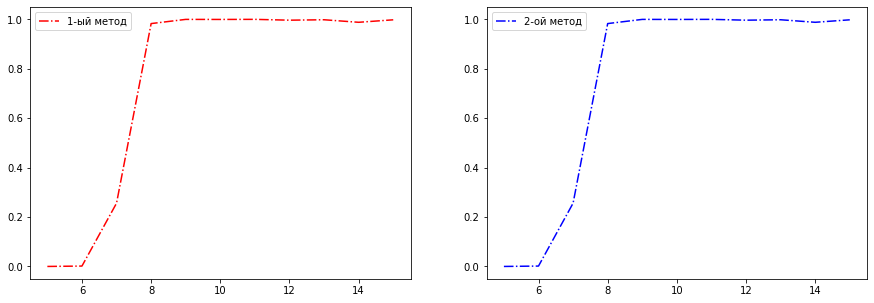

In [17]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(range(5,16), delta_x1, color = 'red', ls = 'dashdot', label = '1-ый метод')
ax[1].plot(range(5,16), delta_x2, color = 'blue', ls = 'dashdot', label = '2-ой метод')
ax[0].legend()
ax[1].legend()
#ax[2].plot(range(5,16), delta_x3, color = 'green', ls = 'dashdot')

Как видно из графиков погрешности обоих методов получились одинаковыми.\
Это логично, ведь перестановки не должны влиять на точность решения.

Задача 3.2 Дана система уравнений  Ax=b  порядка n с разреженной матрицей A. Решить систему прямым методом.

На  побочной диагонали  элементы  равны  100, элементы 5-го и 15-го столбцов равны 10.

Ясно, что можно рассмотреть 45ю и 35ю строку. В этих строках все элементы будут равны нулю\
кроме $ x_5 $ и $ x_{15} $ Тогда сначала найдем решение системы с двумя уравнениями и двумя неизвестными.\
После чего сможем найти остальные неизвестные.

In [18]:
def solve(p, q, b):
    x = np.zeros(50)
    x[4] = ((b[45]*q/p) - b[35])/(q*q/p - p)
    x[14] = (b[35] - p*x[4])/q
    for i in range(50):
        if (i!=35) and (i!=45):
            x[49-i] = ((b[i] - p * (x[4]) - p * (x[14]))/q)
            
    return x

Тестовый пример. Коэффициенты $ x_5 $ и $ x_{15} $ равны соответственно 2 и 1. Вектор b состоит из троек.\
Ясно, что $ x_5 = 1 $ и $ x_{15} = 1 $, а остальные $ x_{1..50} = -1 $ 

In [19]:
p_t = 2
q_t = 1
b_t = [3]*50
print(solve(p_t, q_t, b_t))

[-1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


Решим задачу:

In [14]:
b = np.zeros(50)
p = 10
q = 100
for i in range(50):
    b[i] = (i+1) * np.exp(10/(i+1))
print(solve(p, q, b))

[5.15522165e-01 5.05755935e-01 4.96000134e-01 4.86255475e-01
 5.29469709e-01 4.66802777e-01 4.57096528e-01 4.47405022e-01
 4.37729398e-01 4.28070910e-01 4.18430952e-01 4.08811073e-01
 3.99212995e-01 3.89638647e-01 4.22322433e-01 3.70570055e-01
 3.61080988e-01 3.51626098e-01 3.42208927e-01 3.32833518e-01
 3.23504513e-01 3.14227269e-01 3.05007995e-01 2.95853932e-01
 2.86773576e-01 2.77776960e-01 2.68876017e-01 2.60085050e-01
 2.51421349e-01 2.42906010e-01 2.34565040e-01 2.26430860e-01
 2.18544406e-01 2.10958097e-01 2.03740139e-01 1.96980892e-01
 1.90802576e-01 1.85374505e-01 1.80937893e-01 1.77847945e-01
 1.76648969e-01 1.78216646e-01 1.84048222e-01 1.96912158e-01
 2.22490189e-01 2.74273591e-01 3.92120544e-01 7.45769533e-01
 2.87308397e+00 2.20169479e+02]


Задание 3.3

Элементы матрицы A задаются формулами: $ a_{ij} = \frac{cos(i+j)}{0.1 \beta} + 0.1 \beta e^{-(i-j)^2} $,\
Параметр $ \beta = (|66-N|+5)m $

N = 16, m = 25

Метод: Метод минимальных поправок,\
B –диагональная матрица, содержащая  главную диагональ матрицы A и наддиагональ матрицы А

Создадим матрицу A и B

In [20]:
m = 25
beta = (66-16+1)*m
A = np.array([[(np.cos(i+j)/(0.1*beta) + 0.1*beta*np.exp(-(i-j)**2)) for j in range (m)] for i in range (m)])

In [21]:
B1 = np.eye(m) + np.eye(m, k=1)
B = np.multiply(B1, A)
x = np.array([16]*m)


b = A @ x

Напишем что-то вроде метода прогонки. Он понадобится для промежуточных вычислений в основном методе.

In [43]:
def diag(A, b):
    n = A.shape[0]-1
    x = np.zeros(n+1)
    x[n] = b[n] / A[n][n]
    for i in range(1, n+1):
        x[n-i] = (b[n-i] - A[n-i][n-i+1]*x[n-i+1])/A[n-i][n-i]
    return x

Метод минимальных поправок:

In [44]:
def min_change(A, B, b, eps):
    x = np.zeros(m)
    it = 0
    r = A@x - b
    omega = diag(B,r)
    nu = diag(B, A@omega)
    tau = np.dot(A@omega, omega)/np.dot(nu, A@omega)
    buf = diag(B, B@x - tau * r)
    while (lg.norm(buf-x, ord = 2) > eps):
        x = buf
        r = A@x - b
        omega -= tau * nu
        nu = diag(B, A@omega)
        tau = (np.dot(A@omega, omega)/np.dot(nu, A@omega))
        buf = diag(B, B@x - tau*r)
        it += 1
    return (x, it)

In [45]:
print(min_change(A, B, b, 1e-12))

(array([16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.]), 36)


Ответ полностью совпадает.